# AIML331 Assignment 1
## crowelenn | 300607096

In [1]:
import numpy as np

## Question 1: Camera Problem

**1.1** Your pinhole camera is at [X, Y, Z] = [0, 0, −10]] and sits on a horizontal table. It is pointing 30 degrees to the right relative to the origin of the world coordinates. Compute the [R, t] matrix converting world coordinates to camera coordinates.

In [2]:
from numpy import cos, sin

In [3]:
yaw = np.radians(30)
pitch = np.radians(0)
roll = np.radians(0)

a = pitch # yaw becomes pitch with Z pointing into the page
b = yaw # pitch becomes yaw with Z pointing into the page
y = roll # this remains roll

In [4]:
R = np.array(
    [
        [cos(b)*cos(y), sin(a)*sin(b)*cos(y) - cos(a)*sin(y), cos(a)*sin(b)*cos(y) + sin(a)*sin(y)],
        [cos(b)*sin(y), sin(a)*sin(b)*sin(y) + cos(a)*cos(y), cos(a)*sin(b)*sin(y) - sin(a)*cos(y)],
        [-sin(b), sin(a)*cos(b), cos(a)*cos(b)]
    ])

In [5]:
R = np.concatenate((R, np.array([[0, 0, 0]]).T), axis=1)
R = np.concatenate((R, [[0, 0, 0, 1]]), axis=0)

In [6]:
T = np.array([[0, 0, -10]]).T

In [7]:
t = np.concatenate((np.eye(3), T), axis=1)
t = np.concatenate((t, [[0, 0, 0, 1]]), axis=0)

In [8]:
# display the RT matrix
R @ t

array([[ 0.8660254 ,  0.        ,  0.5       , -5.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.5       ,  0.        ,  0.8660254 , -8.66025404],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

**1.2** Your camera has f = 0.1 (focal length, as used in pinhole camera). Using homogeneous coordinates compute the equation of a line on the projective plane that goes through the points that correspond to [0, 1, 0] and [0, 0, 1] in the world coordinates

In [9]:
f = 0.1

In [10]:
K = np.array([[f, 0, 0, 0],
              [0, f, 0, 0],
              [0, 0, 1, 0]])

In [11]:
world_1 = np.array([[0, 1, 0, 1]]).T # first world coordinates in the homogenous space
world_2 = np.array([[0, 0, 1, 1]]).T # second world coordinates in the homogenous space

In [12]:
def doCameraModel(world_coord, _k, _r, _t):
    proj = _k @ _r @ _t @ world_coord # pass through the transformation matrices
    return proj / proj[-1] # normalize the homogenous coordinates back to cartesian

In [13]:
proj_1 = doCameraModel(world_1, K, R, t)
proj_2 = doCameraModel(world_2, K, R, t)

Find the equation of the line going through the points. To do this, simply take the cross product of the coordinates.

In [14]:
# the cross product of coordinates in the homogeneous projected space is the line through the points on the projective plane.
cross = np.cross(proj_1.T, proj_2.T)
cross

array([[-1.15470054e-02, -6.93889390e-18,  6.66666667e-04]])

In [15]:
cross = cross.reshape(-1)

In [16]:
x = np.linspace(-0.25, 0.25, 100)
y = (cross[2] - -cross[0]*x)/cross[1]

Plot the points and the line camera sensor

In [17]:
import matplotlib.pyplot as plt

In [18]:
def do_plot(coords, _x, _y, _xlim=0.25, _ylim=0.25):
    for coord in coords:
        plt.plot(coord[0], coord[1], 'o', c='blue')

    plt.plot(_x, _y) # plot the line

    plt.xlim(-_xlim, _xlim)
    plt.ylim(-_ylim, _ylim)
    plt.grid()
    plt.show()

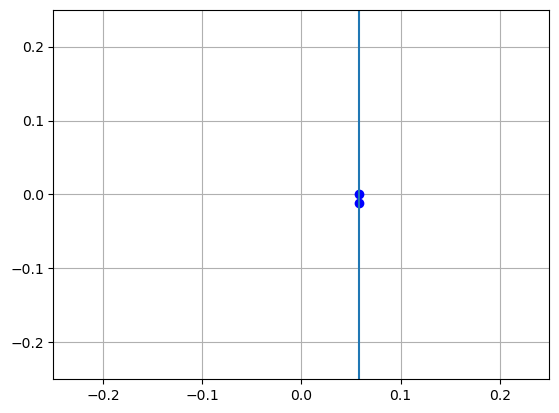

In [19]:
do_plot([proj_1, proj_2], x, y)

## Question 2: Checkerboard Problem
**2.1** Find an image on-line that displays a checkerboard (provide source website). Convert to grey scale if it is colour.


In [20]:
from PIL import Image

In [21]:
checkerboard = np.array(Image.open("check.jpg").convert("L"))

In [22]:
# checking that the checkerboard image has loaded correctly
checkerboard.shape

(400, 400)

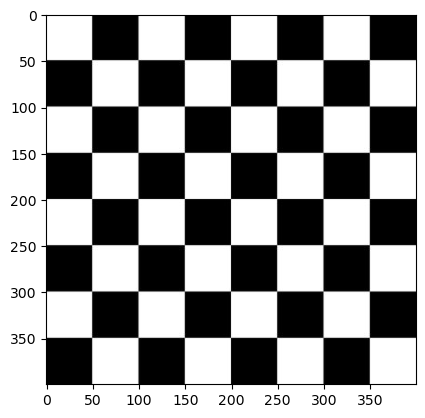

In [23]:
plt.imshow(checkerboard, cmap='gray', vmin=0, vmax=255)

This image is already in greyscale so doesn't need to be converted.

**2.2** Write a program to compute the histogram and cumulative probability function
of the image and display result.

In [24]:
import matplotlib.pyplot as plt

In [25]:
def find_historgam(np_image):
    hist = np.zeros(256)

    for i in np_image.reshape(-1):
        hist[i] += 1

    return hist

In [26]:
def find_cdf(np_image):
    hist = find_historgam(np_image)
    im_total = np_image.reshape(-1).shape[0]
    cdf = np.zeros(256)

    for i in range(256):
        cdf[i] = hist[0:i+1].sum() / im_total

    return cdf

Text(0.5, 1.0, 'Histogram of the checkerboard image')

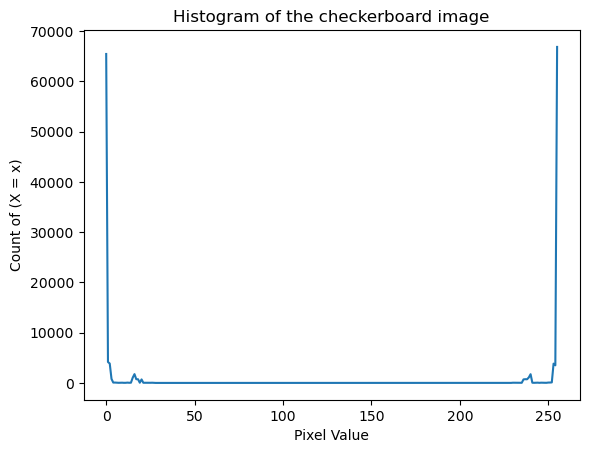

In [27]:
plt.plot(find_historgam(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the checkerboard image")

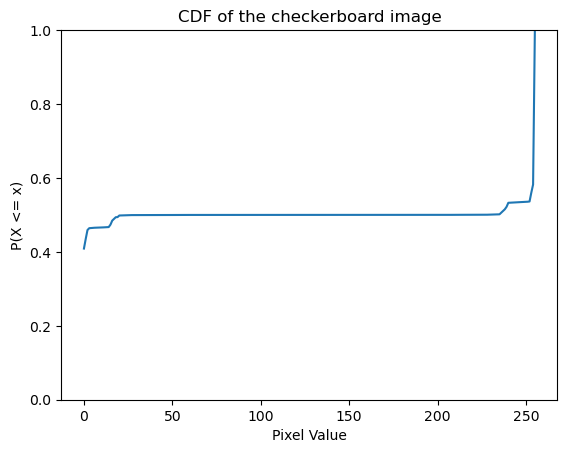

In [28]:
plt.plot(find_cdf(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("P(X <= x)")
plt.ylim(0, 1)
plt.title("CDF of the checkerboard image")
plt.show()

**2.3** Write a program to low-pass filter (smooth) the image in the spatial domain.
You can select the filter.

I am going to use a box filter.

In [29]:
kernel = np.ones((10, 10)) # create a box filter (a 10x10 matrix of 1's)

In [30]:
def do_convolution(image, kernel):
    N, M = kernel.shape # dimensions of the kernel
    output_image = np.zeros(image.shape) # 'copy' the convolution results to this image
    kernel_sum = np.sum(kernel) # add up the kernel value - this is just for normalization

    # we need half the kernel width added to each side of the image
    # otherwise the filter can't be passed over the edges of the image
    # // does floor division - which is useful here because the pad values need to be integers
    pad_h = N // 2
    pad_w = M // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # iterate through each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # implementing the formula for a convolution
            output_image[i, j] = np.sum(kernel * padded_image[i:i+N, j:j+M]) / kernel_sum

    # cast to integers and return the image with the convolution applied
    return output_image.astype(np.uint8)

In [31]:
output = Image.fromarray(do_convolution(checkerboard, kernel))

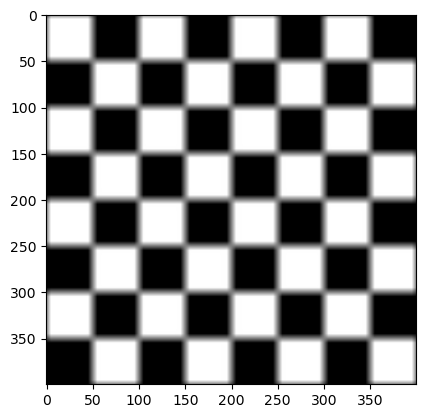

In [32]:
plt.imshow(output, cmap='gray', vmin=0, vmax=255)

**2.4** Explain if the low-pass filter you selected is separable.

A separable kernel can be reduced to a product of two vectors (1D filters). My filter is a $10 \times 10$ matrix of 1's, with a normalisation term of $\frac{1}{100}$. This can be expressed as the product of two vectors as follows:

![my filter](separable%20matrix.png)



Therefore, my matrix is separable. This is a useful property that can be used to reduce the computational complexity of performing a convolution.


**2.5** Write a program to perform the same low-pass filtering in the frequency domain (may use a library for the DFT/FFT operator).

In [33]:
kernel = kernel/100 # normalising the kernel

In [34]:
# to avoid having the periodic nature of DFT causing the right hand side of the image
# getting padded on the left hand side (and the same for the top/bottom), the image can be
# padded to double its original size, with black (0's) in the following 400 pixels on each
# side of the image.
padded_image = np.zeros((800, 800))
padded_image[:400, :400] = checkerboard

In [35]:
# building the kernel - it must be the same size as the image
padded_kernel = np.zeros((800, 800))
# place the box filter in the corner of the new kernel
padded_kernel[0:10, 0:10] = kernel

# calculate the DFT's of both the image and the kernel
Im_fft = np.fft.fft2(padded_image)
Kernel_fft = np.fft.fft2(padded_kernel)

In [36]:
# element-wise multiplication
# multiplication in the frequency domain is the same as convolution in the signal domain
frequency_convolution = np.multiply(Im_fft, Kernel_fft)

In [37]:
# take the real component of the inverse of the DFT pairwise multiplication
image_dft_convolution_padded = np.fft.ifft2(frequency_convolution).real

In [38]:
image_dft_convolution = image_dft_convolution_padded[5:405, 5:405]

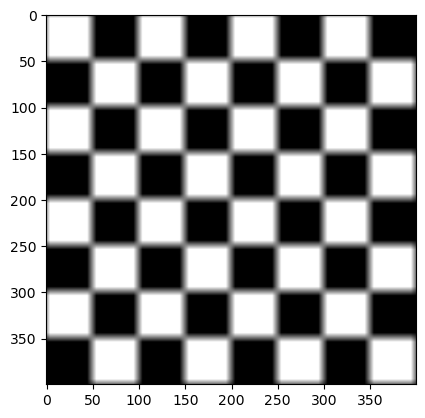

In [39]:
plt.imshow(image_dft_convolution, cmap='gray', vmin=0, vmax=255)

**2.6** Compute the histogram of the low-pass filtered checkerboard image.

Text(0.5, 1.0, 'Histogram of the filtered checkerboard image')

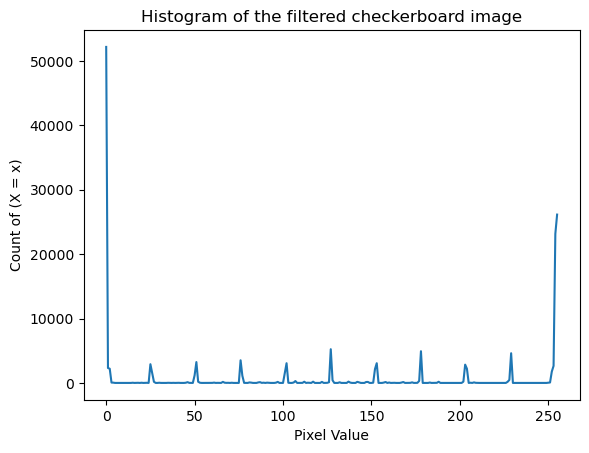

In [40]:
plt.plot(find_historgam(image_dft_convolution.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the filtered checkerboard image")

**2.7** Using cumulative distribution functions, convert your low-pass filtered checkerboard image to have a uniform probability of intensity levels.

In [41]:
# this isn't used. But this is the formula for finding the cdf.
# I kept this here to give some context to 'cdf_inverse', which
# is the inverse of this function.
def cdf_uniform(x):
    return x/255

In [42]:
def cdf_inverse(x):
    return 255*x

In [43]:
def map_to_cdf(image, cdf_inv):
    image_copy = image.copy() # this will be the output image. Pixel intensities get updated here.
    intensities_map = cdf_inv(find_cdf(image.astype(np.uint8))) # apply the equation j' = cd^-1(c(j)). This uses numpy arrays to apply cdf_inv to each intensity value

    # loop through the image and apply the mapping to the target CDF for each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_copy[i, j] = intensities_map[image[i, j]] # update the output image by looking up the new intensity


    return image_copy

In [44]:
# use the function to apply a uniform probability density to the low-pass checkerboard
image_flattened = map_to_cdf(image_dft_convolution.astype(np.uint8), cdf_inverse)

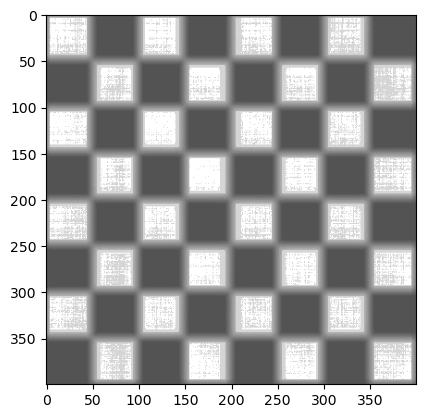

In [45]:
# display the adjusted, filtered checkerboard
plt.imshow(image_flattened, cmap='gray', vmin=0, vmax=255)

Text(0.5, 1.0, 'Histogram of the flattened checkerboard image')

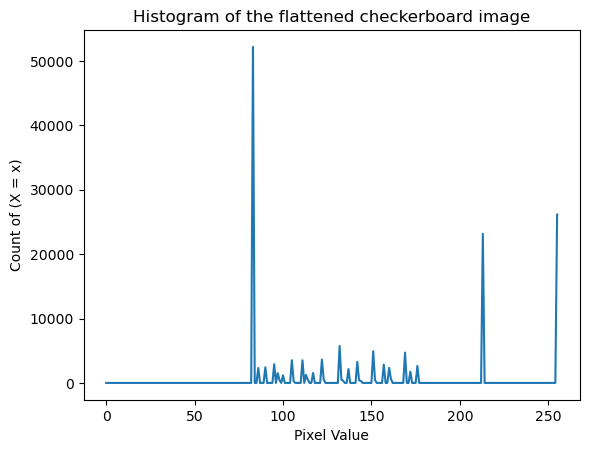

In [46]:
# show the histogram of the flattened checkerboard image
plt.plot(find_historgam(image_flattened.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the flattened checkerboard image")